# RidgeCV Model

#### Data Import / Cleaning / Scaling

The code under this subheader is taken from the '03 LASSO Model' file of this repository. Details on each step can be found in the comments there. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.linear_model import RidgeCV

In [2]:
train = pd.read_csv('datasets/clean_train.csv')
test = pd.read_csv('datasets/test.csv')

In [3]:
train.drop([960], axis=0, inplace= True) 
train.drop([1885], axis=0, inplace= True)
train.drop([1409], axis=0, inplace= True)
train.drop([1566], axis=0, inplace= True)
train.drop([1605], axis=0, inplace= True)
train.drop([1035], axis=0, inplace= True)
train.drop([1141], axis=0, inplace= True)
train.drop([1939], axis=0, inplace= True)

In [4]:
numeric_columns = train._get_numeric_data().columns
numeric_train = train[numeric_columns]
numeric_train = numeric_train.fillna(0)

In [5]:
X = numeric_train.drop(columns=['SalePrice'])
y = numeric_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
pf = PolynomialFeatures(include_bias=False)
pf.fit(X_train);

In [7]:
X_train_pf = pf.transform(X_train)
X_test_pf = pf.transform(X_test)

In [8]:
ss = StandardScaler()
ss.fit(X_train_pf);

In [9]:
X_train_pfs = ss.transform(X_train_pf)
X_test_pfs = ss.transform(X_test_pf)

#### Fitting to RidgeCV Model

In [10]:
# Creating a range of possible values for the alpha hyperparameter

ridge_alphas = np.logspace(0,5,100)

In [11]:
# Instantiating an fitting a RidgeCV model, 'ridge_cv'

ridge_cv = RidgeCV(
    alphas = ridge_alphas,
    scoring='r2',
    cv=5)
ridge_cv.fit(X_train_pfs, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [12]:
# Creating a new dataframe, #r_coef to show the coefficients of each feature

r_coef = pd.DataFrame({
    'feature': pf.get_feature_names(numeric_columns),
    'coef': ridge_cv.coef_
})


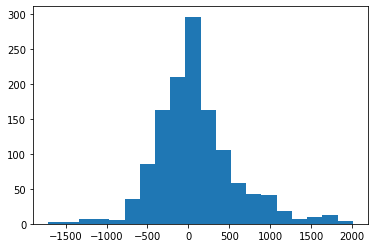

In [13]:
#Exploring the distribution of coefficients

plt.hist(r_coef['coef'], bins=20);

In [14]:
# Displaying the largest 10 negative and positive coefficients 

r_coef.sort_values('coef', ascending=False).head(10)

,feature,coef
295,Overall Qual Total Bsmt SF,2008.168115
284,Overall Qual^2,1984.131176
292,Overall Qual BsmtFin SF 1,1975.450041
467,Mas Vnr Area Bsmt Full Bath,1934.934129
722,Total Bsmt SF Half Bath,1798.384143
502,Exter Qual 1st Flr SF,1791.340085
371,Year Built^2,1787.638110
7,Year Built,1783.555355
412,Year Built Yr Sold,1780.378017
620,BsmtFin SF 1 Half Bath,1755.932817


In [15]:
r_coef.sort_values('coef', ascending=False).tail(10)

,feature,coef
183,MS SubClass Wood Deck SF,-1181.657277
159,MS SubClass Bsmt Unf SF,-1209.294604
484,Mas Vnr Area Wood Deck SF,-1284.957987
137,PID Open Porch SF,-1300.338231
1229,Open Porch SF^2,-1316.541257
147,MS SubClass Lot Frontage,-1353.096506
179,MS SubClass Garage Area,-1424.377848
456,Mas Vnr Area Exter Cond,-1641.678741
974,Half Bath^2,-1663.640896
621,BsmtFin SF 1 Bedroom AbvGr,-1709.439573


In [16]:
# Finding the cross_val_score with 3 folds

cross_val_score(ridge_cv, X_train_pfs, y_train, cv=3)#.mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


array([0.9108315 , 0.92195971, 0.92321942])

In [17]:
# Scoring the training and testing subsets

ridge_cv.fit(X_train_pfs, y_train)
ridge_cv.score(X_train_pfs, y_train), ridge_cv.score(X_test_pfs, y_test)

(0.9489131628557989, 0.9012429045500537)

In [18]:
# Converting the test dataframe columns to match train dataframe

test['PID'] = test['PID'].astype(object)

def rank_test_column(column):   
    test[column] = test[column].str.replace('Ex', '5')
    test[column] = test[column].str.replace('Gd', '4')
    test[column] = test[column].str.replace('TA', '3')
    test[column] = test[column].str.replace('Fa', '2')
    test[column] = test[column].str.replace('Po', '1')
    test[column] = test[column].fillna(0)
    test[column] = test[column].astype(int)
    return

rank_test_column('Exter Qual')
rank_test_column('Exter Cond')
rank_test_column('Heating QC')
rank_test_column('Kitchen Qual')
rank_test_column('Garage Qual')
rank_test_column('Garage Cond')
rank_test_column('Pool QC')
rank_test_column('Bsmt Cond')

In [19]:
test['Paved Drive'] = test['Paved Drive'].str.replace('Y', '3')
test['Paved Drive'] = test['Paved Drive'].str.replace('P', '2')
test['Paved Drive'] = test['Paved Drive'].str.replace('N', '1')
test['Paved Drive'] = test['Paved Drive'].astype(int)

In [20]:
test['Functional'] = test['Functional'].str.replace('Typ', '6')
test['Functional'] = test['Functional'].str.replace('Min2', '5')
test['Functional'] = test['Functional'].str.replace('Min1', '5')
test['Functional'] = test['Functional'].str.replace('Mod', '4')
test['Functional'] = test['Functional'].str.replace('Maj1', '3')
test['Functional'] = test['Functional'].str.replace('Maj2', '3')
test['Functional'] = test['Functional'].str.replace('Sev', '2')
test['Functional'] = test['Functional'].str.replace('Sal', '1')
test['Functional'] = test['Functional'].astype(int)

In [21]:
test['Garage Finish'] = test['Garage Finish'].str.replace('Fin', '3')
test['Garage Finish'] = test['Garage Finish'].str.replace('RFn', '2')
test['Garage Finish'] = test['Garage Finish'].str.replace('Unf', '1')
test['Garage Finish'] = test['Garage Finish'].fillna(0)
test['Garage Finish'] = test['Garage Finish'].astype(int)

In [22]:
# Creating a list of features equal to the independent variables.
# Creating a new dataframe called test_numeric by masking the original test dataframe with "features"
# Filling NaN values with 0 to match training dataset

features = numeric_columns.drop(['SalePrice'])
test_numeric = test[features]
test_numeric = test_numeric.fillna(0)

In [23]:
# Transforming test_numeric using polynomial transformation and standard scaler

test_numeric_pf = pf.transform(test_numeric)
test_numeric_pfs = ss.transform(test_numeric_pf)

In [24]:
# Generating predictions and saving predictions as a new column

predictions = ridge_cv.predict(test_numeric_pfs)
test['SalePrice'] = predictions

In [25]:
# Writing csv file with Lasso predictions

holly_predictions = test[['Id','SalePrice']]
holly_predictions.to_csv('datasets/Holly_Preds_Ridge.csv', index=False)